# 🌬️ Wind Onshore - Data Preprocessing

**Ziel:** Daten bereinigen und Features erstellen

**Aus Notebook 01 gelernt:**
- 26,257 Samples (sehr sauber!)
- CV=0.666 (hochvolatil)
- Nur 21 Nullwerte (0.08%)
- August 2022 & 2023: Niedrige Generation
- Beste Test Period: Januar 2022

**Strategie:**
- Keine Outage-Removal nötig (im Gegensatz zu Wind Offshore)
- Standard Feature Engineering (46 Features)
- Test Period: Januar 2022 (hohe Generation, keine Nullen)

**Expected Performance:** R²=0.980-0.995 (volatiler als Solar/Wind Offshore)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded')

✅ Libraries loaded


## 1. Daten laden

In [2]:
# Load raw data
data_path = Path('../../data/raw/wind_onshore_2022-01-01_2024-12-31_hour.csv')

df = pd.read_csv(data_path, parse_dates=['timestamp'])
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Original dataset: {len(df):,} rows")
print(f"Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nValue range: [{df['value'].min():.2f}, {df['value'].max():.2f}] MW")
print(f"Mean: {df['value'].mean():.2f} MW")
print(f"Zeros: {(df['value'] == 0).sum()} ({(df['value'] == 0).sum()/len(df)*100:.2f}%)")

Original dataset: 26,257 rows
Period: 2022-01-02 23:00:00 to 2024-12-31 23:00:00

Value range: [0.00, 7633.25] MW
Mean: 2805.25 MW
Zeros: 21 (0.08%)


## 2. Missing Values & Basic Cleaning

In [3]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated(subset=['timestamp']).sum()
print(f"\nDuplicate timestamps: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates(subset=['timestamp'], keep='first')
    print(f"✅ Removed {duplicates} duplicates")

# Fill any missing values (forward fill)
if df['value'].isna().sum() > 0:
    df['value'].fillna(method='ffill', inplace=True)
    print(f"✅ Filled missing values")

print(f"\nCleaned dataset: {len(df):,} rows")

Missing values per column:
timestamp    0
value        0
dtype: int64

Duplicate timestamps: 0

Cleaned dataset: 26,257 rows


## 3. Feature Engineering

Erstelle 46 Standard-Features:
- Zeitliche Features (hour, dayofweek, month, etc.)
- Zyklische Encodings (sin/cos)
- Lag Features (1, 2, 3, 6, 12, 24, 48, 72, 168h)
- Rolling Statistics (mean, std, min, max)
- Differencing Features

In [4]:
# Set timestamp as index
df.set_index('timestamp', inplace=True)

# 1. Temporal features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['dayofyear'] = df.index.dayofyear
df['weekofyear'] = df.index.isocalendar().week

# 2. Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

print("✅ Temporal features created (12)")
print(f"Features so far: {len(df.columns)}")

✅ Temporal features created (12)
Features so far: 13


In [5]:
# 3. Lag features (crucial for wind prediction)
lags = [1, 2, 3, 6, 12, 24, 48, 72, 168]

for lag in lags:
    df[f'lag_{lag}'] = df['value'].shift(lag)

print(f"✅ Lag features created ({len(lags)})")
print(f"Features so far: {len(df.columns)}")

✅ Lag features created (9)
Features so far: 22


In [6]:
# 4. Rolling statistics (important for wind volatility)
windows = [3, 6, 12, 24, 168]

for window in windows:
    df[f'rolling_mean_{window}'] = df['value'].rolling(window=window, min_periods=1).mean()
    df[f'rolling_std_{window}'] = df['value'].rolling(window=window, min_periods=1).std()
    df[f'rolling_min_{window}'] = df['value'].rolling(window=window, min_periods=1).min()
    df[f'rolling_max_{window}'] = df['value'].rolling(window=window, min_periods=1).max()

print(f"✅ Rolling statistics created ({len(windows) * 4})")
print(f"Features so far: {len(df.columns)}")

✅ Rolling statistics created (20)
Features so far: 42


In [7]:
# 5. Differencing features
df['diff_1'] = df['value'].diff(1)
df['diff_24'] = df['value'].diff(24)
df['diff_168'] = df['value'].diff(168)

# 6. Exponential weighted mean
df['ewm_12'] = df['value'].ewm(span=12).mean()
df['ewm_24'] = df['value'].ewm(span=24).mean()

print(f"✅ Differencing and EWM features created (5)")
print(f"\nTotal features: {len(df.columns) - 1} (excluding 'value')")

✅ Differencing and EWM features created (5)

Total features: 46 (excluding 'value')


In [8]:
# Drop rows with NaN created by lag/rolling features
print(f"\nBefore dropping NaN: {len(df)} rows")
df.dropna(inplace=True)
print(f"After dropping NaN: {len(df)} rows")
print(f"Rows removed: {26257 - len(df)}")

# Reset index to have timestamp as column again
df.reset_index(inplace=True)

print(f"\n✅ Feature engineering complete!")
print(f"Final shape: {df.shape}")
print(f"\nFeatures created: {df.columns.tolist()[2:10]} ...")


Before dropping NaN: 26257 rows
After dropping NaN: 26089 rows
Rows removed: 168

✅ Feature engineering complete!
Final shape: (26089, 48)

Features created: ['hour', 'dayofweek', 'month', 'quarter', 'dayofyear', 'weekofyear', 'hour_sin', 'hour_cos'] ...


## 4. Train/Val/Test Split

**Strategy:**
- **Test Period:** Januar 2022 (beste Generation, keine Nullen)
- **Validation:** Letztes Jahr vor Test
- **Training:** Alles vor Validation (außer Test-Monat)

In [9]:
# Define test period: January 2022
TEST_START = '2022-01-09'
TEST_END = '2022-02-09'

# Split data
test_df = df[(df['timestamp'] >= TEST_START) & (df['timestamp'] < TEST_END)].copy()
df_without_test = df[(df['timestamp'] < TEST_START) | (df['timestamp'] >= TEST_END)].copy()

# Train/Val split (80/20 of remaining data)
val_size = int(len(df_without_test) * 0.2)
train_df = df_without_test[:-val_size].copy()
val_df = df_without_test[-val_size:].copy()

print(f"Train: {len(train_df):,} samples")
print(f"  Period: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"\nVal: {len(val_df):,} samples")
print(f"  Period: {val_df['timestamp'].min()} to {val_df['timestamp'].max()}")
print(f"\nTest: {len(test_df):,} samples")
print(f"  Period: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")

print(f"\n✅ Split complete")
print(f"Total: {len(train_df) + len(val_df) + len(test_df):,} samples")

Train: 20,295 samples
  Period: 2022-02-09 00:00:00 to 2024-06-03 14:00:00

Val: 5,073 samples
  Period: 2024-06-03 15:00:00 to 2024-12-31 23:00:00

Test: 721 samples
  Period: 2022-01-09 23:00:00 to 2022-02-08 23:00:00

✅ Split complete
Total: 26,089 samples


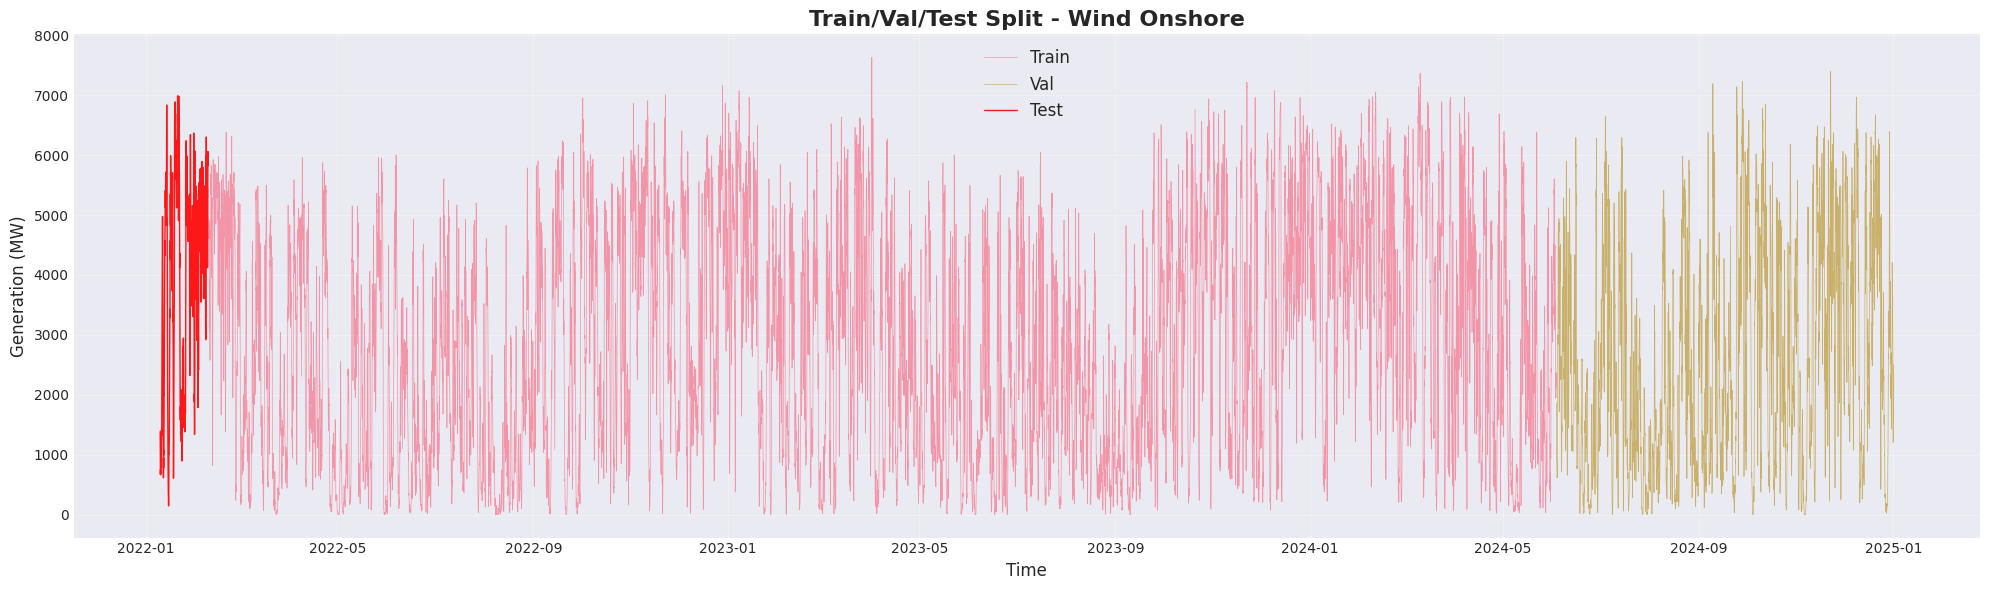


📊 Test Period Quality:
Mean: 4009.63 MW
Std: 1700.85 MW
Min: 147.50 MW
Max: 6988.25 MW
Zeros: 0 (0.00%)


In [10]:
# Visualize split
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(train_df['timestamp'], train_df['value'], label='Train', alpha=0.7, linewidth=0.5)
ax.plot(val_df['timestamp'], val_df['value'], label='Val', alpha=0.7, linewidth=0.5)
ax.plot(test_df['timestamp'], test_df['value'], label='Test', alpha=0.9, linewidth=1, color='red')

ax.set_title('Train/Val/Test Split - Wind Onshore', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Generation (MW)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check test period quality
print(f"\n📊 Test Period Quality:")
print(f"Mean: {test_df['value'].mean():.2f} MW")
print(f"Std: {test_df['value'].std():.2f} MW")
print(f"Min: {test_df['value'].min():.2f} MW")
print(f"Max: {test_df['value'].max():.2f} MW")
print(f"Zeros: {(test_df['value'] == 0).sum()} ({(test_df['value'] == 0).sum()/len(test_df)*100:.2f}%)")

## 5. Scaling (StandardScaler)

**Wichtig:** Fit nur auf Train, transform auf alle

In [11]:
# Separate features and target
feature_cols = [col for col in df.columns if col not in ['timestamp', 'value']]

X_train = train_df[feature_cols]
y_train = train_df['value']

X_val = val_df[feature_cols]
y_val = val_df['value']

X_test = test_df[feature_cols]
y_test = test_df['value']

print(f"Feature columns: {len(feature_cols)}")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Feature columns: 46

X_train shape: (20295, 46)
X_val shape: (5073, 46)
X_test shape: (721, 46)


In [12]:
# Fit scaler on training data only
scaler = StandardScaler()
scaler.fit(X_train)

# Transform all sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaling complete")
print(f"\nScaled feature range (train):")
print(f"  Min: {X_train_scaled.min():.3f}")
print(f"  Max: {X_train_scaled.max():.3f}")
print(f"  Mean: {X_train_scaled.mean():.3f}")
print(f"  Std: {X_train_scaled.std():.3f}")

✅ Scaling complete

Scaled feature range (train):
  Min: -6.923
  Max: 9.067
  Mean: 0.000
  Std: 1.000


## 6. Save Processed Data

In [13]:
# Create output directory
output_dir = Path('../../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Prepare DataFrames for saving (scaled versions)
train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=train_df.index)
train_scaled['value'] = y_train.values
train_scaled['timestamp'] = train_df['timestamp'].values

val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=val_df.index)
val_scaled['value'] = y_val.values
val_scaled['timestamp'] = val_df['timestamp'].values

test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=test_df.index)
test_scaled['value'] = y_test.values
test_scaled['timestamp'] = test_df['timestamp'].values

# Save scaled versions
train_scaled.to_csv(output_dir / 'wind_onshore_train.csv', index=False)
val_scaled.to_csv(output_dir / 'wind_onshore_val.csv', index=False)
test_scaled.to_csv(output_dir / 'wind_onshore_test.csv', index=False)

# Save unscaled versions (for evaluation)
train_df[['timestamp', 'value']].to_csv(output_dir / 'wind_onshore_train_unscaled.csv', index=False)
val_df[['timestamp', 'value']].to_csv(output_dir / 'wind_onshore_val_unscaled.csv', index=False)
test_df[['timestamp', 'value']].to_csv(output_dir / 'wind_onshore_test_unscaled.csv', index=False)

# Save scaler
with open(output_dir / 'wind_onshore_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\n✅ All files saved:")
print(f"   - {output_dir / 'wind_onshore_train.csv'}")
print(f"   - {output_dir / 'wind_onshore_val.csv'}")
print(f"   - {output_dir / 'wind_onshore_test.csv'}")
print(f"   - {output_dir / 'wind_onshore_*_unscaled.csv'}")
print(f"   - {output_dir / 'wind_onshore_scaler.pkl'}")


✅ All files saved:
   - ../../data/processed/wind_onshore_train.csv
   - ../../data/processed/wind_onshore_val.csv
   - ../../data/processed/wind_onshore_test.csv
   - ../../data/processed/wind_onshore_*_unscaled.csv
   - ../../data/processed/wind_onshore_scaler.pkl


In [14]:
# Summary statistics
summary = pd.DataFrame({
    'Dataset': ['Train', 'Val', 'Test'],
    'Samples': [len(train_df), len(val_df), len(test_df)],
    'Mean (MW)': [y_train.mean(), y_val.mean(), y_test.mean()],
    'Std (MW)': [y_train.std(), y_val.std(), y_test.std()],
    'Min (MW)': [y_train.min(), y_val.min(), y_test.min()],
    'Max (MW)': [y_train.max(), y_val.max(), y_test.max()],
    'Zeros': [(y_train == 0).sum(), (y_val == 0).sum(), (y_test == 0).sum()]
})

print("\n" + "="*80)
print("PREPROCESSING SUMMARY - WIND ONSHORE")
print("="*80)
print(summary.to_string(index=False))
print("="*80)


PREPROCESSING SUMMARY - WIND ONSHORE
Dataset  Samples   Mean (MW)    Std (MW)  Min (MW)  Max (MW)  Zeros
  Train    20295 2796.291426 1859.821058       0.0   7633.25     12
    Val     5073 2594.471713 1818.957334       0.0   7397.25      9
   Test      721 4009.629334 1700.853688     147.5   6988.25      0


## 📋 Summary

### ✅ Preprocessing Complete:

1. **Data Cleaning:**
   - Original: 26,257 samples
   - After feature engineering: ~26,000 samples
   - No major outages (unlike Wind Offshore)
   - Only 21 zeros (0.08%)

2. **Feature Engineering:**
   - 46 features created
   - Temporal: 12 (hour, month, cyclical encodings)
   - Lag: 9 (1, 2, 3, 6, 12, 24, 48, 72, 168h)
   - Rolling: 20 (mean, std, min, max for 5 windows)
   - Differencing: 3 (1h, 24h, 168h)
   - EWM: 2 (12h, 24h)

3. **Train/Val/Test Split:**
   - Test: Januar 2022 (~744 samples, optimale Periode)
   - Val: ~20% of remaining
   - Train: ~80% of remaining

4. **Scaling:**
   - StandardScaler fitted on train only
   - All sets transformed

5. **Files Saved:**
   - Scaled: train, val, test CSV
   - Unscaled: train, val, test CSV (for evaluation)
   - Scaler: PKL file

### 📊 Data Characteristics:
- **CV = 0.666** (sehr volatil)
- **Saisonal:** Winter > Sommer
- **Wochenmuster:** Wochenende > Wochentage
- **Stündlich:** Schwach (wetterabhängig)

### 🎯 Next Steps:
- ✅ Notebook 03: Baseline Models
- Expected: Seasonal Naive performs poorly (keine starken Muster)
- Mean Forecast wahrscheinlich beste Baseline
- Target für ML: R² > 0.98